In [38]:
# Basic Packages
from __future__ import division
import os
from datetime import datetime

# Web & file access
import requests
import io

# Import display options for showing websites
from IPython.display import IFrame, HTML
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

%pylab --no-import-all
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

import plotly.express as px
import plotly.graph_objects as go

from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap

# Data
import pandas as pd
import numpy as np
from pandas_datareader import data, wb

# GIS & maps
import geopandas as gpd
gp = gpd
import georasters as gr
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import textwrap
import statsmodels.api as sm
from stargazer.stargazer import Stargazer, LineLocation

# Data Munging
from itertools import product, combinations
import difflib
import pycountry
import geocoder
from geonamescache.mappers import country
mapper = country(from_key='name', to_key='iso3')
mapper2 = country(from_key='iso3', to_key='iso')
mapper3 = country(from_key='iso3', to_key='name')

# Regressions & Stats
from scipy.stats import norm
import statsmodels.formula.api as smf

Using matplotlib backend: QtAgg
Populating the interactive namespace from numpy and matplotlib


In [39]:
# Paths
pathout = './data/'

if not os.path.exists(pathout):
    os.mkdir(pathout)
    
pathgraphs = './graphs/'
if not os.path.exists(pathgraphs):
    os.mkdir(pathgraphs)

In [40]:
currentYear = datetime.now().year
year = min(2020, currentYear-2)

<div class="alert alert-block alert-warning">
    <b>Exercise 1:</b> Get WDI data on <b>patent applications by residents and non-residents in each country</b>. Create a new variable that shows the total patents for each country.
</div>

In [41]:
url = 'https://data.worldbank.org/share/widget?indicators=IP.PAT.NRES'
IFrame(url, width=500, height=300)

In [42]:
url = 'https://data.worldbank.org/share/widget?indicators=IP.PAT.RESD'
IFrame(url, width=500, height=300)

In [43]:
wbcountries = wb.get_countries()
wbcountries = wbcountries.loc[wbcountries.region.isin(['Aggregates'])==False].reset_index(drop=True)
wbcountries['name'] = wbcountries.name.str.strip()
wbcountries['incomeLevel'] = wbcountries['incomeLevel'].str.title()
wbcountries.loc[wbcountries.iso3c=='VEN', 'incomeLevel'] = 'Upper Middle Income'

In [44]:
wdi_indicators = ['IP.PAT.RESD', 'IP.PAT.NRES', 'NY.GDP.PCAP.PP.KD']

In [45]:
pop_vars = wb.search(string='population')
pop_vars.head()

,id,name,unit,source,sourceNote,sourceOrganization,topics
24,1.1_ACCESS.ELECTRICITY.TOT,Access to electricity (% of total population),,Sustainable Energy for All,Access to electricity is the percentage of pop...,b'World Bank Global Electrification Database 2...,
39,1.2_ACCESS.ELECTRICITY.RURAL,Access to electricity (% of rural population),,Sustainable Energy for All,Access to electricity is the percentage of rur...,b'World Bank Global Electrification Database 2...,
40,1.3_ACCESS.ELECTRICITY.URBAN,Access to electricity (% of urban population),,Sustainable Energy for All,Access to electricity is the percentage of tot...,b'World Bank Global Electrification Database 2...,
164,2.1_ACCESS.CFT.TOT,Access to Clean Fuels and Technologies for coo...,,Sustainable Energy for All,,b'',
195,3.11.01.01.popcen,Population census,,Statistical Capacity Indicators,"Population censuses collect data on the size, ...",b'World Bank Microdata library. Original sourc...,


In [46]:
wdi = wb.download(indicator=wdi_indicators, country=wbcountries.iso2c.values, start=1950, end=year)
wdi = wdi.reset_index()
wdi['year'] = wdi.year.astype(int)
wdi['pat_res'] = wdi['IP.PAT.RESD']
wdi['pat_nonres'] = wdi['IP.PAT.NRES']
wdi['pat_total'] = wdi['IP.PAT.RESD'] + wdi['IP.PAT.NRES']
wdi['gdp_pc'] = wdi['NY.GDP.PCAP.PP.KD']
wdi['ln_pat_total'] = wdi['pat_total'].apply(np.log)
wdi['ln_pat_nonres'] = wdi['pat_nonres'].apply(np.log)
wdi['ln_pat_res'] = wdi['pat_res'].apply(np.log)
wdi['ln_gdp_pc'] = wdi['gdp_pc'].apply(np.log)
wdi['ratio'] = wdi['ln_pat_total'] / wdi['ln_gdp_pc']
wdi.head()

C:\Users\skand\anaconda3\envs\EconGrowthUG-Builds-Windows-pip\lib\site-packages\pandas_datareader\wb.py:592: UserWarning:

Non-standard ISO country codes: JG, XK



,country,year,IP.PAT.RESD,IP.PAT.NRES,NY.GDP.PCAP.PP.KD,pat_res,pat_nonres,pat_total,gdp_pc,ln_pat_total,ln_pat_nonres,ln_pat_res,ln_gdp_pc,ratio
0,Aruba,2020,NaN,NaN,29563.756955,NaN,NaN,NaN,29563.756955,NaN,NaN,NaN,10.294304,NaN
1,Aruba,2019,NaN,NaN,38221.117314,NaN,NaN,NaN,38221.117314,NaN,NaN,NaN,10.551143,NaN
2,Aruba,2018,NaN,NaN,39206.356147,NaN,NaN,NaN,39206.356147,NaN,NaN,NaN,10.576594,NaN
3,Aruba,2017,NaN,NaN,38893.960556,NaN,NaN,NaN,38893.960556,NaN,NaN,NaN,10.568594,NaN
4,Aruba,2016,NaN,NaN,37046.877414,NaN,NaN,NaN,37046.877414,NaN,NaN,NaN,10.519939,NaN


In [47]:
wdi = wbcountries.merge(wdi, left_on='name', right_on='country')
wdi.head()

,iso3c,iso2c,name,region,adminregion,incomeLevel,lendingType,capitalCity,longitude,latitude,...,NY.GDP.PCAP.PP.KD,pat_res,pat_nonres,pat_total,gdp_pc,ln_pat_total,ln_pat_nonres,ln_pat_res,ln_gdp_pc,ratio
0,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,29563.756955,NaN,NaN,NaN,29563.756955,NaN,NaN,NaN,10.294304,NaN
1,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,38221.117314,NaN,NaN,NaN,38221.117314,NaN,NaN,NaN,10.551143,NaN
2,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,39206.356147,NaN,NaN,NaN,39206.356147,NaN,NaN,NaN,10.576594,NaN
3,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,38893.960556,NaN,NaN,NaN,38893.960556,NaN,NaN,NaN,10.568594,NaN
4,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,37046.877414,NaN,NaN,NaN,37046.877414,NaN,NaN,NaN,10.519939,NaN


<div class="alert alert-block alert-warning">
<b>Exercise 2:</b> Using the <code>my_xy_plot</code> function plot the relation between <b>GDP per capita</b> and <b>total patents</b> in the years 1990, 1995, 2000, 2010, 2020.
</div>

In [48]:
dffig = wdi.loc[wdi.year==year]\
            .dropna(subset=['gdp_pc', 'ln_pat_total'])\
            .sort_values(by='region').reset_index()

In [49]:
mod = smf.ols(formula='gdp_pc ~ ln_pat_total', data=dffig, missing='drop').fit()

In [50]:
mod.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:               OLS              Adj. R-squared:     0.060     
Dependent Variable:  gdp_pc           AIC:                2443.3548 
Date:                2022-11-06 17:19 BIC:                2448.7005 
No. Observations:    107              Log-Likelihood:     -1219.7   
Df Model:            1                F-statistic:        7.737     
Df Residuals:        105              Prob (F-statistic): 0.00642   
R-squared:           0.069            Scale:              4.7494e+08
--------------------------------------------------------------------
               Coef.     Std.Err.   t    P>|t|    [0.025    0.975]  
--------------------------------------------------------------------
Intercept    12831.5359 5825.0371 2.2028 0.0298 1281.5633 24381.5084
ln_pat_total  2267.3931  815.1739 2.7815 0.0064  651.0540  3883.7323
--------------------------------------------------------------------
Omnibus:               30.200        Durbin-Watson:           1.428 
Prob(Omnibus):         0.000         Jarque-Bera (JB):        47.179
Skew:                  1.299         Prob(JB):                0.000 
Kurtosis:              4.957         Condition No.:           20    
====================================================================

"""

In [51]:
def my_xy_plot(dfin, 
               x='gdp_pc', 
               y='pat_total', 
               labelvar='iso3c', 
               dx=0.006125, 
               dy=0.006125, 
               xlogscale=False, 
               ylogscale=False,
               xlabel='GDP Per Capita', 
               ylabel='Total Patents',
               labels=True,
               xpct = False,
               ypct = False,
               OLS=True,
               OLSlinelabel='OLS',
               ssline=False,
               sslinelabel='45 Degree Line',
               filename='GDP_Patents1.pdf',
               hue='region',
               hue_order=['East Asia & Pacific', 'Europe & Central Asia',
                          'Latin America & Caribbean ', 'Middle East & North Africa',
                          'North America', 'South Asia', 'Sub-Saharan Africa '],
               style='incomeLevel', 
               style_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
               palette=None,
               size=None,
               sizes=None,
               legend_fontsize=10,
               label_font_size=12,
               save=True):
    '''
    Plot the association between x and var in dataframe using labelvar for labels.
    '''
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_context("talk")
    df = dfin.copy()
    df = df.dropna(subset=[x, y]).reset_index(drop=True)
    # Plot
    k = 0
    fig, ax = plt.subplots()
    sns.scatterplot(x=x, y=y, data=df, ax=ax, 
                    hue=hue,
                    hue_order=hue_order,
                    #hue='incomeLevel',
                    #hue_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
                    #hue_order=['East Asia & Pacific', 'Europe & Central Asia',
                    #           'Latin America & Caribbean ', 'Middle East & North Africa',
                    #           'North America', 'South Asia', 'Sub-Saharan Africa '],
                    alpha=1, 
                    style=style, 
                    style_order=style_order,
                    palette=palette,
                    size=size,
                    sizes=sizes,
                    #palette=sns.color_palette("Blues_r", df[hue].unique().shape[0]+6)[:df[hue].unique().shape[0]*2:2],
                )
    if OLS:
        sns.regplot(x=x, y=y, data=df, ax=ax, label=OLSlinelabel, scatter=False)
    if ssline:
        ax.plot([df[x].min()*.99, df[x].max()*1.01], [df[x].min()*.99, df[x].max()*1.01], c='r', label=sslinelabel)
    if labels:
        movex = df[x].mean() * dx
        movey = df[y].mean() * dy
        for line in range(0,df.shape[0]):
            ax.text(df[x][line]+movex, df[y][line]+movey, df[labelvar][line], horizontalalignment='left', fontsize=label_font_size, color='black')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xpct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        xticks = mtick.FormatStrFormatter(fmt)
        ax.xaxis.set_major_formatter(xticks)
    if ypct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        yticks = mtick.FormatStrFormatter(fmt)
        ax.yaxis.set_major_formatter(yticks)
    if ylogscale:
        ax.set(yscale="log")
    if xlogscale:
        ax.set(xscale="log")
    handles, labels = ax.get_legend_handles_labels()
    handles = np.array(handles)
    labels = np.array(labels)
    handles = list(handles[(labels!=hue) & (labels!=style) & (labels!=size)])
    labels = list(labels[(labels!=hue) & (labels!=style) & (labels!=size)])
    ax.legend(handles=handles, labels=labels, fontsize=legend_fontsize)
    if save:
        plt.savefig('C:\\Users\\skand\\Desktop\\Lexi\'s Files\\College\\College Sem 7\\ECO4362-EcoGrowth\\notebooks\\Working-with-WDI-Exercises\\graphs/' + filename, dpi=300, bbox_inches='tight')
    return fig

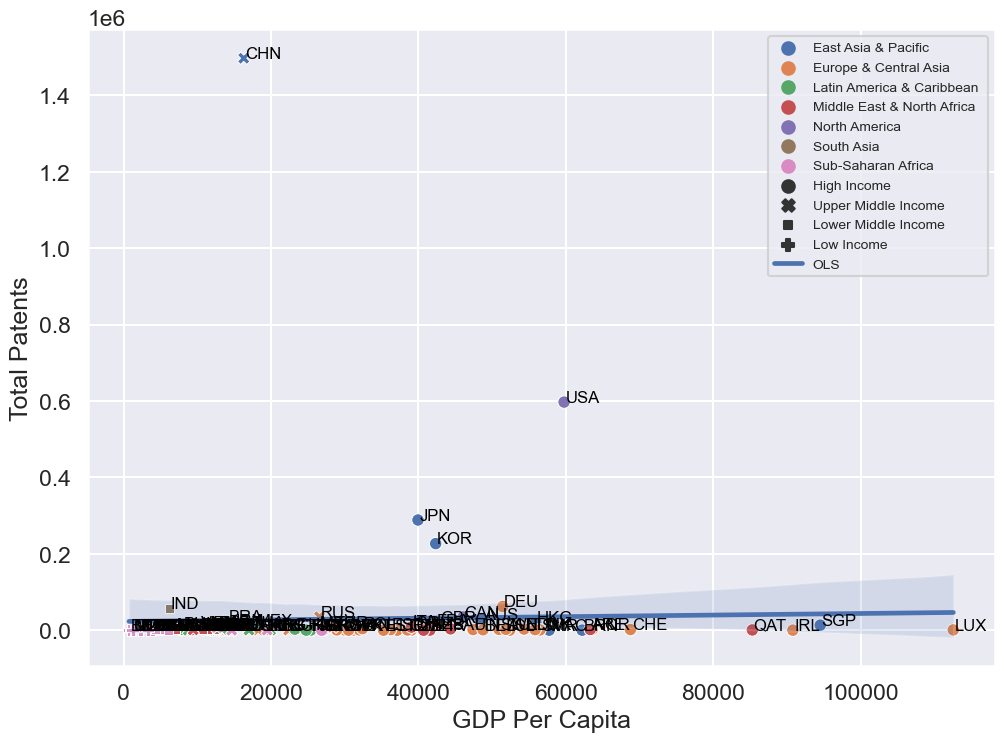

In [52]:
g = my_xy_plot(dffig, 
               x='gdp_pc', 
               y='pat_total', 
               xlabel='GDP Per Capita', 
               ylabel='Total Patents', 
               OLS=True, 
               labels=True, 
               #size="ln_pop", 
               #sizes=(10, 400), 
               filename='GDP-Patents.pdf')

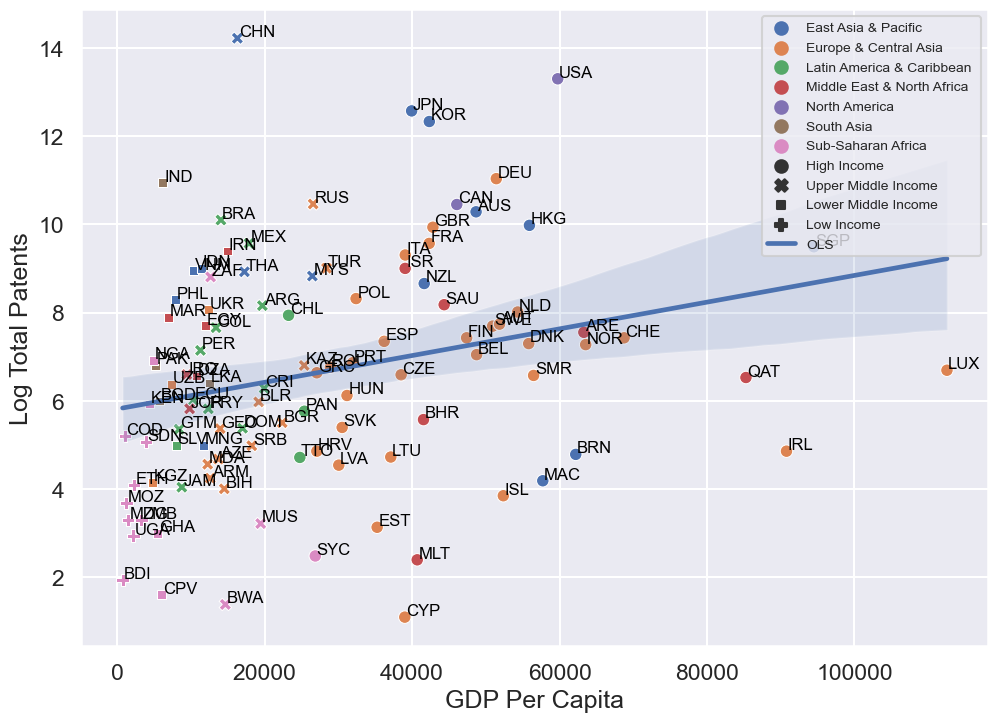

In [53]:
# making the graph easier to read
h = my_xy_plot(dffig, 
               x='gdp_pc', 
               y='ln_pat_total', 
               xlabel='GDP Per Capita', 
               ylabel='Log Total Patents', 
               OLS=True, 
               labels=True, 
               #size="ln_pop", 
               #sizes=(10, 400), 
               filename='GDP-logPatents.pdf')

<div class="alert alert-block alert-warning">
<b>Exercise 3:</b> Using the <code>my_xy_line_plot</code> function plot the evolution of <b>GDP per capita</b> and <b>total patents</b> by income groups and regions (separate figures).
</div>

In [54]:
mod2 = smf.ols(formula='gdp_pc ~ ln_pat_total + C(region)', data=dffig, missing='drop').fit()

In [55]:
def my_xy_line_plot(dfin, 
                    x='gdp_pc', 
                    y='ln_pat_total', 
                    labelvar='iso3c', 
                    dx=0.006125, 
                    dy=0.006125, 
                    xlogscale=False, 
                    ylogscale=False,
                    xlabel='GDP Per Capita', 
                    ylabel='Log Total Patents',
                    labels=True,
                    xpct = False,
                    ypct = False,
                    OLS=False,
                    OLSlinelabel='OLS',
                    ssline=False,
                    sslinelabel='45 Degree Line',
                    filename='GDP-LogPat-RegionC.pdf',
                    hue='region',
                    hue_order=['East Asia & Pacific', 'Europe & Central Asia',
                               'Latin America & Caribbean ', 'Middle East & North Africa',
                               'North America', 'South Asia', 'Sub-Saharan Africa '],
                    style='incomeLevel', 
                    style_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
                    palette=None,
                    legend_fontsize=10,
                    label_fontsize=12,
                    loc=None,
                    save=True):
    '''
    Plot the association between x and var in dataframe using labelvar for labels. 
    '''
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_context("talk")
    df = dfin.copy()
    df = df.dropna(subset=[x, y]).reset_index(drop=True)
    # Plot
    k = 0
    fig, ax = plt.subplots()
    sns.lineplot(x=x, y=y, data=df, ax=ax, 
                    hue=hue,
                    hue_order=hue_order,
                    alpha=1, 
                    style=style, 
                    style_order=style_order,
                    palette=palette,
                )
    if OLS:
        sns.regplot(x=x, y=y, data=df, ax=ax, label=OLSlinelabel, scatter=False)
    if ssline:
        ax.plot([df[x].min()*.99, df[x].max()*1.01], [df[x].min()*.99, df[x].max()*1.01], c='r', label=sslinelabel)
    if labels:
        movex = df[x].mean() * dx
        movey = df[y].mean() * dy
        for line in range(0,df.shape[0]):
            ax.text(df[x][line]+movex, df[y][line]+movey, df[labelvar][line], horizontalalignment='left', fontsize=label_fontsize, color='black')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xpct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        xticks = mtick.FormatStrFormatter(fmt)
        ax.xaxis.set_major_formatter(xticks)
    if ypct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        yticks = mtick.FormatStrFormatter(fmt)
        ax.yaxis.set_major_formatter(yticks)
    if ylogscale:
        ax.set(yscale="log")
    if xlogscale:
        ax.set(xscale="log")
    handles, labels = ax.get_legend_handles_labels()
    handles = np.array(handles)
    labels = np.array(labels)
    handles = list(handles[(labels!='region') & (labels!='incomeLevel')])
    labels = list(labels[(labels!='region') & (labels!='incomeLevel')])
    ax.legend(handles=handles, labels=labels, fontsize=legend_fontsize, loc=loc)
    if save:
        plt.savefig(pathgraphs + filename, dpi=300, bbox_inches='tight')
    return fig

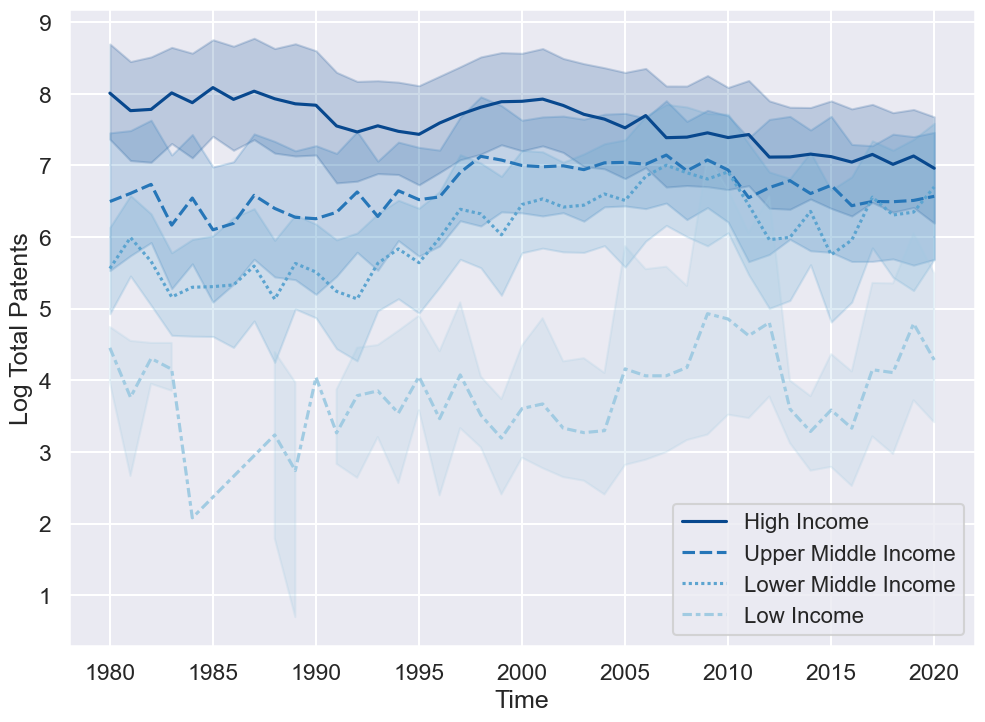

In [56]:
palette=sns.color_palette("Blues_r", wdi['incomeLevel'].unique().shape[0]+6)[:wdi['incomeLevel'].unique().shape[0]*2:2]
fig = my_xy_line_plot(wdi, 
                x='year', 
                y='ln_pat_total', 
                xlabel='Time',
                ylabel='Log Total Patents',
                filename='LnPatents-overTime-IncomeC.pdf',
                hue='incomeLevel',
                hue_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
                palette=palette,
                OLS=False, 
                labels=False,
                legend_fontsize=16,
                loc='lower right',
                save=True)

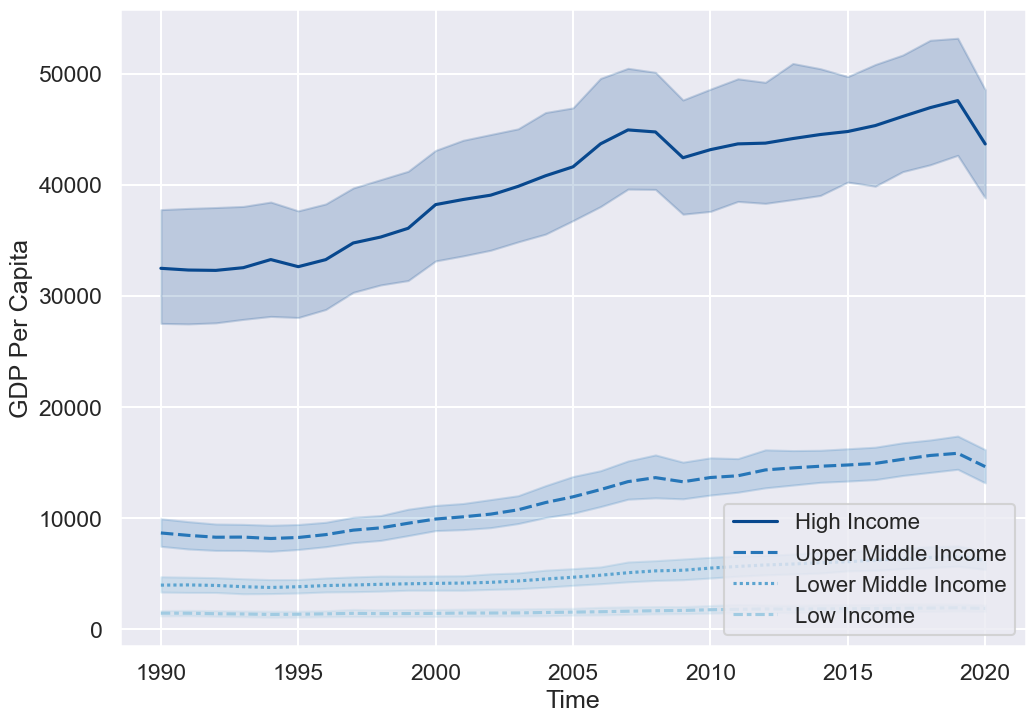

In [57]:
palette=sns.color_palette("Blues_r", wdi['incomeLevel'].unique().shape[0]+6)[:wdi['incomeLevel'].unique().shape[0]*2:2]
fig = my_xy_line_plot(wdi, 
                x='year', 
                y='gdp_pc', 
                xlabel='Time',
                ylabel='GDP Per Capita',
                filename='GDPPC-overTime-IncomeC.pdf',
                hue='incomeLevel',
                hue_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
                palette=palette,
                OLS=False, 
                labels=False,
                legend_fontsize=16,
                loc='lower right',
                save=True)

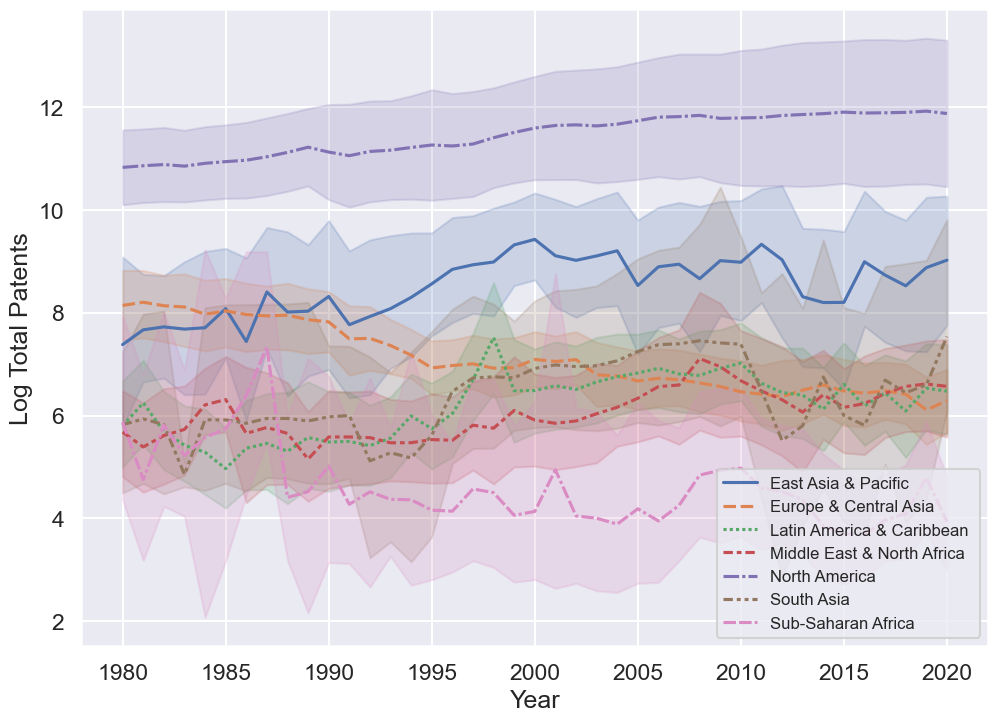

In [58]:
#palette=sns.color_palette("Blues_r", wdi['region'].unique().shape[0]+6)[:wdi['region'].unique().shape[0]*2:2]
fig = my_xy_line_plot(wdi, 
                      x='year', 
                      y='ln_pat_total', 
                      xlabel='Year',
                      ylabel='Log Total Patents',
                      ylogscale=False,
                      filename='LnPatents-overtime-RegionC.pdf',
                      style='region',
                      style_order=['East Asia & Pacific', 'Europe & Central Asia',
                                   'Latin America & Caribbean ', 'Middle East & North Africa',
                                   'North America', 'South Asia', 'Sub-Saharan Africa '],
                      #palette=palette,
                      OLS=False, 
                      labels=False,
                      legend_fontsize=12,
                      loc='lower right',
                      save=True)

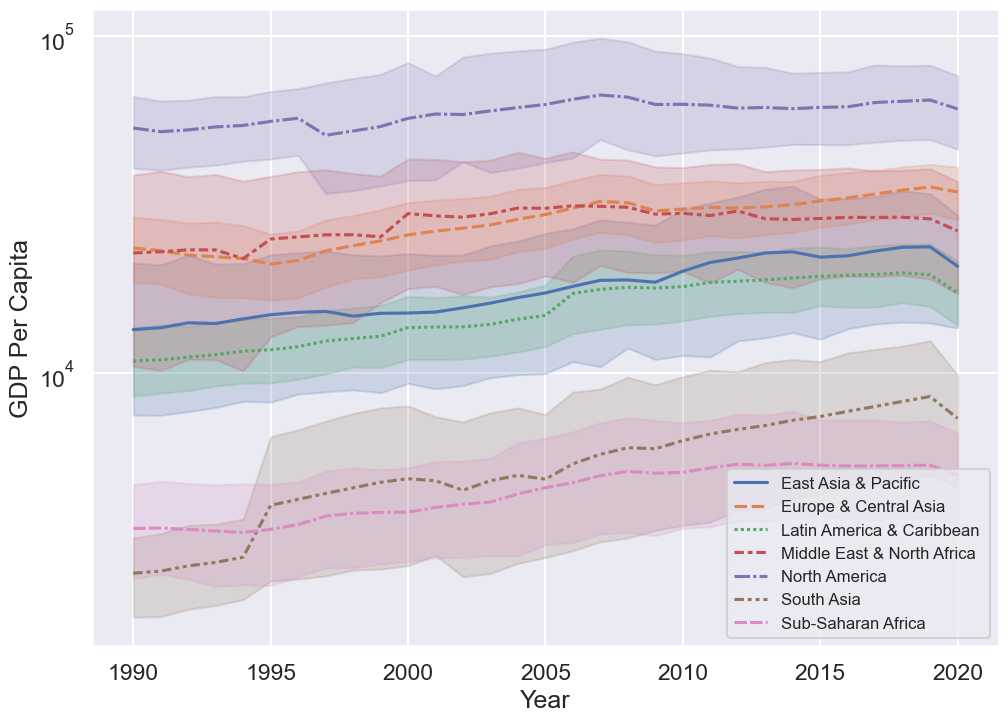

In [59]:
#palette=sns.color_palette("Blues_r", wdi['region'].unique().shape[0]+6)[:wdi['region'].unique().shape[0]*2:2]
fig = my_xy_line_plot(wdi, 
                      x='year', 
                      y='gdp_pc', 
                      xlabel='Year',
                      ylabel='GDP Per Capita',
                      ylogscale=True,
                      filename='GDPPC-overtime-RegionC.pdf',
                      style='region',
                      style_order=['East Asia & Pacific', 'Europe & Central Asia',
                                   'Latin America & Caribbean ', 'Middle East & North Africa',
                                   'North America', 'South Asia', 'Sub-Saharan Africa '],
                      #palette=palette,
                      OLS=False, 
                      labels=False,
                      legend_fontsize=12,
                      loc='lower right',
                      save=True)

<div class="alert alert-block alert-warning">
<b>Exercise 4:</b> Plot the relation between patenting activity by <b>residents and non-residents</b> in the year 2015. Make sure to show the 45 degree line so you can see how similar they are.
</div>

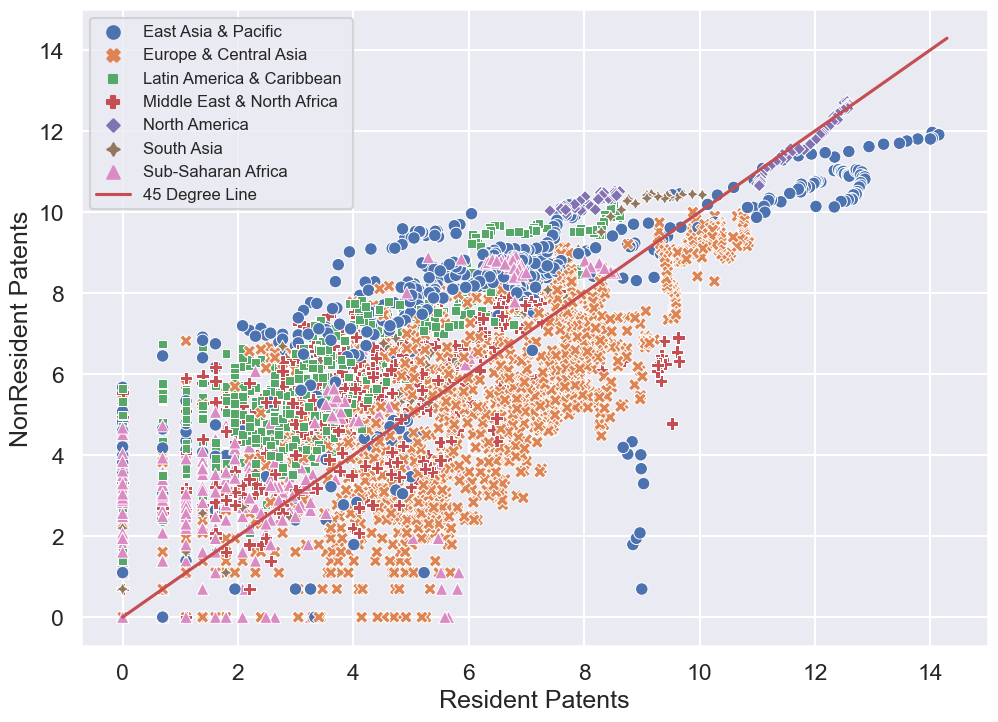

In [60]:
fig = my_xy_plot(wdi,
                 x='ln_pat_res',
                 y='ln_pat_nonres',
                 xlabel='Resident Patents',
                 ylabel='NonResident Patents',
                 ylogscale=False,
                 filename='Patents-2015.pdf',
                 style='region',
                 style_order=['East Asia & Pacific', 'Europe & Central Asia',
                              'Latin America & Caribbean ', 'Middle East & North Africa',
                              'North America', 'South Asia', 'Sub-Saharan Africa '],
                 #palette=palette,
                 OLS=False, 
                 ssline=True,
                 labels=False,
                 legend_fontsize=12,
                 #loc='lower right',
                 save=True)

<div class="alert alert-block alert-warning">
<b>Exercise 5:</b> Create a static and a dynamic map for patenting activity in the year 2015 across the world. 
</div>

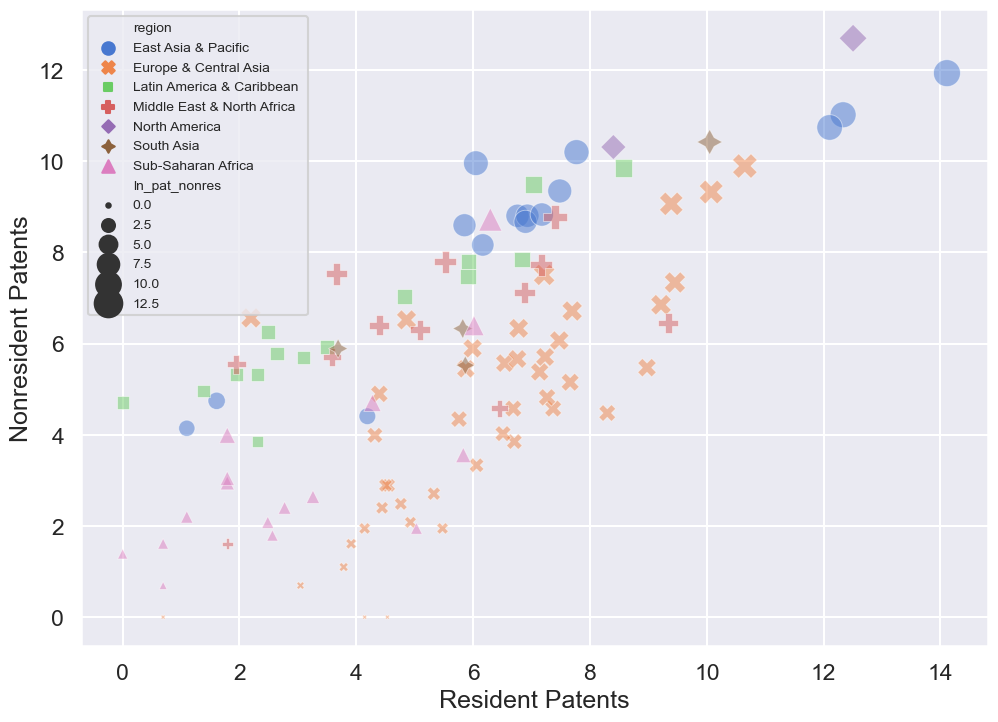

In [61]:
#static using seaborn
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

fig, ax = plt.subplots()
sns.scatterplot(x="ln_pat_res", 
                y="ln_pat_nonres", 
                data=dffig,
                hue="region",
                hue_order = dffig.region.drop_duplicates().sort_values(),
                style="region",
                style_order = dffig.region.drop_duplicates().sort_values(),
                size="ln_pat_nonres",
                sizes=(10, 400), 
                alpha=.5, 
                palette="muted",
                ax=ax
               )
ax.set_xlabel('Resident Patents')
ax.set_ylabel('Nonresident Patents')
ax.legend(fontsize=10)

In [62]:
#dynamic chart
symbols = ['circle', 'x', 'square', 'cross', 'diamond', 'star-diamond', 'triangle-up']
fig = px.scatter(dffig,
                 x="ln_pat_res", 
                 y="ln_pat_nonres", 
                 color='region',
                 symbol='region',
                 symbol_sequence=symbols,
                 hover_name='name',
                 hover_data=['iso3c', 'ln_pat_res', 'ln_pat_nonres'],
                 size='ln_pat_nonres',
                 size_max=15,
                 trendline="ols",
                 trendline_scope="overall",
                 trendline_color_override="black",
                 labels={
                     "ln_pat_res": "Log Resident Patents",
                     "ln_pat_nonres": "Log NonResident Patents",
                     "region": "WB Region"
                 },
                 opacity=0.75,
                 height=800,
                )

In [63]:
fig.show()

<div class="alert alert-block alert-warning">
<b>Exercise 6:</b> Explore the relation between economic development as measured by Log[GDP per capita] and patenting activity. Show the relation for residents, non-residents, and total, all in one nice looking table. Also, produce a few nice looking figures.
</div>

In [64]:
wdi.head()

,iso3c,iso2c,name,region,adminregion,incomeLevel,lendingType,capitalCity,longitude,latitude,...,NY.GDP.PCAP.PP.KD,pat_res,pat_nonres,pat_total,gdp_pc,ln_pat_total,ln_pat_nonres,ln_pat_res,ln_gdp_pc,ratio
0,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,29563.756955,NaN,NaN,NaN,29563.756955,NaN,NaN,NaN,10.294304,NaN
1,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,38221.117314,NaN,NaN,NaN,38221.117314,NaN,NaN,NaN,10.551143,NaN
2,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,39206.356147,NaN,NaN,NaN,39206.356147,NaN,NaN,NaN,10.576594,NaN
3,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,38893.960556,NaN,NaN,NaN,38893.960556,NaN,NaN,NaN,10.568594,NaN
4,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,37046.877414,NaN,NaN,NaN,37046.877414,NaN,NaN,NaN,10.519939,NaN


### Methodology
I decided to create a new variable of GDP:Total Patent Ratio. This ratio will indicate how many patents there are compared to the GDP per Capita

In [65]:
wdi['ratio'] = wdi['ln_pat_total'] / wdi['ln_gdp_pc']

In [66]:
symbols = ['circle', 'x', 'square', 'cross', 'diamond', 'star-diamond', 'triangle-up']
fig = px.scatter(dffig,
                 x="ln_gdp_pc", 
                 y="ratio", 
                 color='region',
                 symbol='region',
                 symbol_sequence=symbols,
                 hover_name='name',
                 hover_data=['iso3c', 'ln_gdp_pc', 'ratio'],
                 size='ratio',
                 size_max=15,
                 trendline="ols",
                 trendline_scope="overall",
                 trendline_color_override="black",
                 labels={
                     "ln_gdp_pc": "Log GDP Per Capita",
                     "ratio": "Patents: GDP Per Capita Ratio",
                     "region": "WB Region"
                 },
                 opacity=0.75,
                 height=800,
                )

In [67]:
fig.show()

The above chart shows the ratio of GDP per Capita compared to the gdp/patents ratio. The OLS shows how there is little to no correlation between GDP per Capita and having a higher number of patents compared to GDP.If anything, there is a slight positive upward correlation, however the R2 is only .01, meaning the correlation is essentially up to chance. 

Another interesting note is that region seems to have little influence over the Patent: GDP per capita ratio. Although there is a clear differentiation in region for GDP per Capita (i.e. Sub-Saharan Africa is concentrated in the lower-left quadrant and North America in the upper-right), ther seems to be a lot of differentiation between states concerning patent use. For example, while China is a clear outlier with high patent:GDP ratio, Mongolia has a similar GDP but lower than average patent production. Africa is similarly distributed, with the Congo exceeding the trend line and Botswana and Burundei far below it. There must be some other factor which would explain the deviation in these trends. 

In [68]:
symbols = ['circle', 'x', 'square', 'cross', 'diamond', 'star-diamond', 'triangle-up']
fig2 = px.scatter(dffig,
                 x="ln_pat_res", 
                 y="ratio", 
                 color='region',
                 symbol='region',
                 symbol_sequence=symbols,
                 hover_name='name',
                 hover_data=['iso3c', 'ln_pat_res', 'ratio'],
                 size='ratio',
                 size_max=15,
                 trendline="ols",
                 trendline_scope="overall",
                 trendline_color_override="black",
                 labels={
                     "ln_pat_res": "Log Resident Patents",
                     "ratio": "Patents: GDP Per Capita Ratio",
                     "region": "WB Region"
                 },
                 opacity=0.75,
                 height=800,
                )

In [69]:
fig2.show()

In [70]:
symbols = ['circle', 'x', 'square', 'cross', 'diamond', 'star-diamond', 'triangle-up']
fig3 = px.scatter(dffig,
                 x="ln_pat_nonres", 
                 y="ratio", 
                 color='region',
                 symbol='region',
                 symbol_sequence=symbols,
                 hover_name='name',
                 hover_data=['iso3c', 'ln_pat_nonres', 'ratio'],
                 size='ratio',
                 size_max=15,
                 trendline="ols",
                 trendline_scope="overall",
                 trendline_color_override="black",
                 labels={
                     "ln_pat_nonres": "Log Nonresident Patents",
                     "ratio": "Patents: GDP Per Capita Ratio",
                     "region": "WB Region"
                 },
                 opacity=0.75,
                 height=800,
                )

In [71]:
fig3.show()

In [72]:
symbols = ['circle', 'x', 'square', 'cross', 'diamond', 'star-diamond', 'triangle-up']
fig4 = px.scatter(dffig,
                 x="ln_pat_total", 
                 y="ratio", 
                 color='region',
                 symbol='region',
                 symbol_sequence=symbols,
                 hover_name='name',
                 hover_data=['iso3c', 'ln_pat_total', 'ratio'],
                 size='ratio',
                 size_max=15,
                 trendline="ols",
                 trendline_scope="overall",
                 trendline_color_override="black",
                 labels={
                     "ln_pat_total": "Total Patents",
                     "ratio": "Patents: GDP Per Capita Ratio",
                     "region": "WB Region"
                 },
                 opacity=0.75,
                 height=800,
                )

In [73]:
fig4.show()

## Findings  

After the breakdown of the above graphs, the only clear trend that I could find was that Europe and Central Asia consistently produced more resident patents than nonresident patents. All three trends (concerning res. pat, nonres. pat, and total pats.) showed no clear distinctions between patents and GDP. The trend lines are somewhat deceptive, as the trend lines have slopes between 0.0 and 0.3, meaning a change in patents only changes the ratio by less than .3%. These elasticity is extremely rigid, indicating that GDP and patent production are relatively unlinked. 